<a href="https://colab.research.google.com/github/rajsahu2004/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [37]:
# Check for GPU
try:
  %nvidia-smi
except:
  print('No GPU found')

No GPU found


In [53]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.1.0+cu118


'cpu'

## 1. What are 3 areas in industry where computer vision is currently being used?

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [40]:
import torchvision
from torchvision import datasets,transforms

train_data = datasets.MNIST(root='data',train=True,download=True,transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transforms.ToTensor())
train_data,test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 6. Visualize at least 5 different samples of the MNIST training dataset.

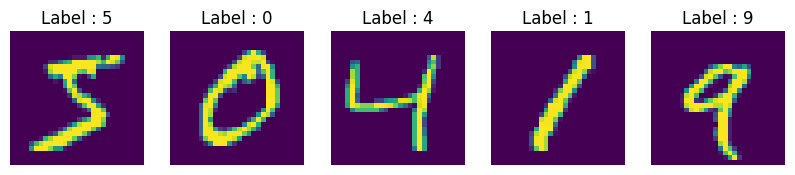

In [49]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,2))
for i in range(5):
  img = train_data[i][0].squeeze()
  label = train_data[i][1]
  fig.add_subplot(1,5,i+1)
  plt.imshow(img)
  plt.title(f'Label : {label}')
  plt.axis('off')

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [50]:
train_dataloader = torch.utils.data.DataLoader(train_data,32,True)
test_dataloader = torch.utils.data.DataLoader(test_data,32,False)
len(train_dataloader),len(test_dataloader)

(1875, 313)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [62]:
from torch import nn
class MNIST_model(nn.Module):
  def __init__(self,in_shape,hidden_shape,out_shape):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_shape,hidden_shape,3,1,1),
        nn.ReLU(),
        nn.Conv2d(hidden_shape,hidden_shape,3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_shape,hidden_shape,3,1,1),
        nn.ReLU(),
        nn.Conv2d(hidden_shape,hidden_shape,3,1,1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_shape*7*7,out_shape)
    )
  def forward(self,x):
    out = self.conv_block1(x)
    out = self.conv_block2(out)
    out = self.classifier(out)
    return out

In [63]:
model = MNIST_model(1,10,10)
model

MNIST_model(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [64]:
%%time
from tqdm.auto import tqdm
from torchmetrics import Accuracy

loss_func = nn.CrossEntropyLoss()
acc_func = Accuracy(task='MULTICLASS',num_classes=len(train_data.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=1e-2)

epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss = 0
  train_acc = 0
  for batch,(x_train,y_train) in enumerate(train_dataloader):
    model.eval()
    x_train,y_train = x_train.to(device),y_train.to(device)
    y_pred = model.forward(x_train)
    loss = loss_func(y_pred,y_train)
    acc = acc_func(y_pred,y_train)
    train_loss += loss
    train_acc += acc
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  test_total_loss, test_total_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for batch, (x_test,y_test) in enumerate(test_dataloader):
      x_test,y_test = x_test.to(device), y_test.to(device)
      test_pred = model.forward(x_test)
      test_loss = loss_func(test_pred,y_test)
      test_total_loss += test_loss
      test_acc = acc_func(test_pred,y_test)
      test_total_acc += test_acc
    test_total_loss /= len(test_dataloader)
    test_total_acc /= len(test_dataloader)
  print(f'Epoch : {epoch+1} | Train Loss : {train_loss:.3f} | Train Acc : {train_acc:.3f} | Test Loss : {test_total_loss:.3f} | Test Acc : {test_total_acc:.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0 | Train Loss : 1.153 | Train Acc : 0.593 | Test Loss : 0.176 | Test Acc : 0.948
Epoch : 1 | Train Loss : 0.149 | Train Acc : 0.954 | Test Loss : 0.098 | Test Acc : 0.969
Epoch : 2 | Train Loss : 0.100 | Train Acc : 0.969 | Test Loss : 0.075 | Test Acc : 0.976
Epoch : 3 | Train Loss : 0.083 | Train Acc : 0.975 | Test Loss : 0.072 | Test Acc : 0.976
Epoch : 4 | Train Loss : 0.072 | Train Acc : 0.978 | Test Loss : 0.059 | Test Acc : 0.982
CPU times: user 3min 21s, sys: 582 ms, total: 3min 21s
Wall time: 3min 22s


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

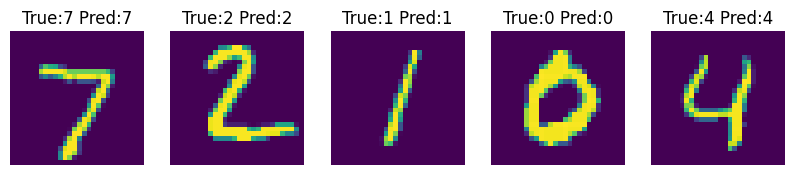

In [70]:
fig = plt.figure(figsize=(10,2))
for i in range(5):
  img = test_data[i][0]
  label = test_data[i][1]
  pred_logits = model.forward(img.unsqueeze(dim=0)).to(device)
  pred_probs = torch.softmax(pred_logits,dim=1)
  pred_labels = torch.argmax(pred_probs,dim=1)
  fig.add_subplot(1,5,i+1)
  plt.imshow(img.squeeze())
  plt.title(f'True:{label} Pred:{pred_labels.item()}')
  plt.axis('off')

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [75]:
model.eval()
y_preds = []
with torch.inference_mode():
  for batch,(x,y) in tqdm(enumerate(test_dataloader),total=len(test_dataloader)):
    x,y = x.to(device),y.to(device)
    y_preds_logits = model.forward(x)
    y_preds_probs = torch.softmax(y_preds_logits,dim=1)
    y_preds_labels = torch.argmax(y_preds_probs,dim=1)
    y_preds.append(y_preds_labels)
  y_preds = torch.cat(y_preds)
len(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

10000

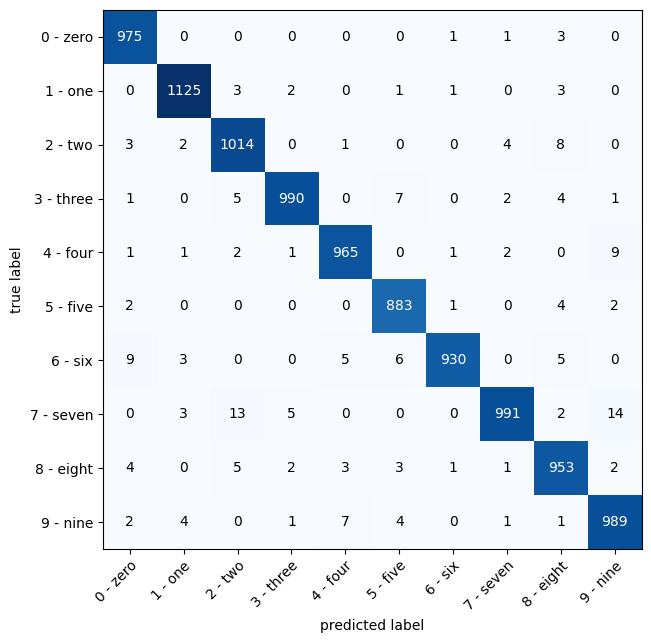

In [77]:
try:
  from torchmetrics import ConfusionMatrix
  from mlxtend.plotting import plot_confusion_matrix
except:
  %pip install torchmetrics
  %pip install mlxtend
  from torchmetrics import ConfusionMatrix
  from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(train_data.classes))
confmat_tensor = confmat(preds=y_preds,target=test_data.targets)
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=train_data.classes,
    figsize=(10, 7)
)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [78]:
random_tensor = torch.rand([1, 3, 64, 64])
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=64,
                       kernel_size=3,
                       stride=2,
                       padding=1)
print(f"Random tensor original shape: {random_tensor.shape}")
random_tensor_through_conv_layer = conv_layer(random_tensor)
print(f"Random tensor through conv layer shape: {random_tensor_through_conv_layer.shape}")

Random tensor original shape: torch.Size([1, 3, 64, 64])
Random tensor through conv layer shape: torch.Size([1, 64, 32, 32])


## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [80]:
fashion_mnist_train = datasets.FashionMNIST(root="data",download=True,train=True,transform=transforms.ToTensor())
fashion_mnist_test = datasets.FashionMNIST(root="data",train=False,download=True,transform=transforms.ToTensor())
fashion_mnist_class_names = fashion_mnist_train.classes
len(fashion_mnist_train), len(fashion_mnist_test)

(60000, 10000)

In [81]:
fashion_mnist_train_dataloader = torch.utils.data.DataLoader(fashion_mnist_train,batch_size=32,shuffle=True)
fashion_mnist_test_dataloader = torch.utils.data.DataLoader(fashion_mnist_test,batch_size=32,shuffle=False)
len(fashion_mnist_train_dataloader), len(fashion_mnist_test_dataloader)

(1875, 313)

In [83]:
model2 = MNIST_model(1,10,10).to(device)
model2

MNIST_model(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [86]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)
acc_func = Accuracy(task="MULTICLASS",num_classes=len(fashion_mnist_class_names)).to(device)

In [87]:
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss, test_loss_total = 0, 0
  train_acc, test_acc = 0, 0
  model2.train()
  for batch, (X_train, y_train) in enumerate(fashion_mnist_train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_pred = model2(X_train)
    loss = loss_func(y_pred, y_train)
    train_loss += loss
    train_acc += acc_func(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(fashion_mnist_train_dataloader)
  train_acc /= len(fashion_mnist_train_dataloader)
  model2.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(fashion_mnist_test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_pred_test = model2(X_test)
      test_loss = loss_func(y_pred_test, y_test)
      test_loss_total += test_loss
      test_acc += acc_func(y_pred_test, y_test)
    test_loss /= len(fashion_mnist_test_dataloader)
    test_acc /= len(fashion_mnist_test_dataloader)
  print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Test loss: {test_loss_total:.3f} | Test acc: {test_acc:.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.489 | Train acc: 0.45 | Test loss: 210.080 | Test acc: 0.76
Epoch: 1 | Train loss: 0.577 | Train acc: 0.79 | Test loss: 156.044 | Test acc: 0.82
Epoch: 2 | Train loss: 0.459 | Train acc: 0.83 | Test loss: 139.658 | Test acc: 0.85
Epoch: 3 | Train loss: 0.411 | Train acc: 0.85 | Test loss: 138.194 | Test acc: 0.84
Epoch: 4 | Train loss: 0.381 | Train acc: 0.86 | Test loss: 127.030 | Test acc: 0.85


In [88]:
test_preds = []
model2.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_mnist_test_dataloader,total=len(fashion_mnist_test_dataloader)):
    y_logits = model2(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds)
test_preds[:10], len(test_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

In [89]:
import numpy as np
wrong_pred_indexes = np.where(test_preds != fashion_mnist_test.targets)[0]
len(wrong_pred_indexes)

1480

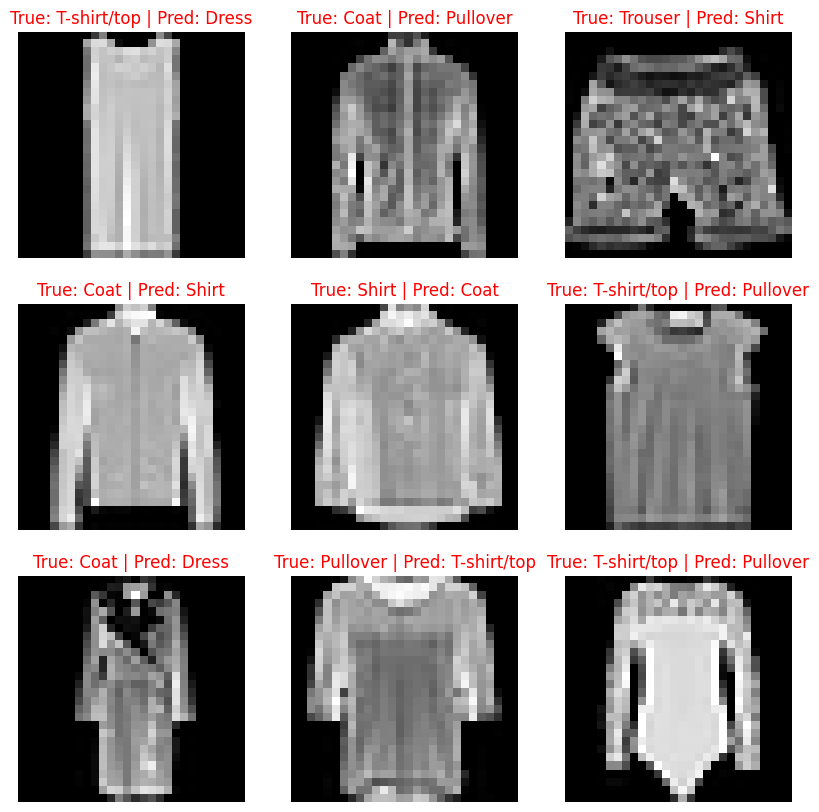

In [90]:
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  true_label = fashion_mnist_class_names[fashion_mnist_test[idx][1]]
  pred_label = fashion_mnist_class_names[test_preds[idx]]
  # Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_mnist_test[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False);